In [1]:
# %% [code] 1_DATA_PREP: stable features for Fig-7 work
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/combined_wallets_with_transactions_and_balances_3.csv')

# Ensure correct dtypes
df['isSafe'] = df['isSafe'].astype(int)

# --- Drop non-features
non_feature_cols = ['Address','Name','Tags','Transactions','approved_token_list']
feat_df = df.drop(columns=non_feature_cols, errors='ignore').copy()

# --- Known collinearity from your analysis: drop both or at least one
for col in ['total_transactions','tx_burst_count']:
    if col in feat_df.columns:
        feat_df.drop(columns=[col], inplace=True)

# --- Fill NA robustly
feat_df = feat_df.fillna(feat_df.median(numeric_only=True))

# --- Define X,y
y = feat_df['isSafe'].astype(int)
X = feat_df.drop(columns=['isSafe'], errors='ignore')


In [4]:
# %% [code] 2_SPLIT_AND_SCALE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

rng = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=rng
)

scale_cols = [c for c in ['Balance','noOfTrx.1','avg_txn_value_eth','value_std_dev'] if c in X.columns]
scaler = MinMaxScaler()
if scale_cols:
    X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols].values)
    X_test[scale_cols]  = scaler.transform(X_test[scale_cols].values)


In [5]:
# %% [code] 3A_CALIBRATED_RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report

base_rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
cal_rf   = CalibratedClassifierCV(base_rf, method='isotonic', cv=5)  # or method='sigmoid' (Platt)

cal_rf.fit(X_train, y_train)
y_prob_after = cal_rf.predict_proba(X_test)[:,1]
y_pred_after = (y_prob_after >= 0.5).astype(int)

print("Calibrated RF AUC:", roc_auc_score(y_test, y_prob_after))
print(classification_report(y_test, y_pred_after, digits=4))


Calibrated RF AUC: 0.9915237303357316
              precision    recall  f1-score   support

           0     0.8941    0.9616    0.9266      1563
           1     0.9882    0.9657    0.9768      5187

    accuracy                         0.9647      6750
   macro avg     0.9411    0.9636    0.9517      6750
weighted avg     0.9664    0.9647    0.9652      6750



In [7]:
# # %% [code] 3B_REGRESSOR_PLUS_ISOTONIC  (run instead of 3A if you keep GBR)
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.isotonic import IsotonicRegression
# from sklearn.metrics import roc_auc_score

# gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=10,
#                                 subsample=0.8, min_samples_split=5, random_state=42)
# gbr.fit(X_train, y_train.astype(float))
# raw_prob = np.clip(gbr.predict(X_test), 0, 1)

# iso = IsotonicRegression(out_of_bounds='clip')
# iso.fit(raw_prob, y_test)
# y_prob_after = iso.transform(raw_prob)
# y_pred_after = (y_prob_after >= 0.5).astype(int)

# print("GBR + Isotonic AUC:", roc_auc_score(y_test, y_prob_after))


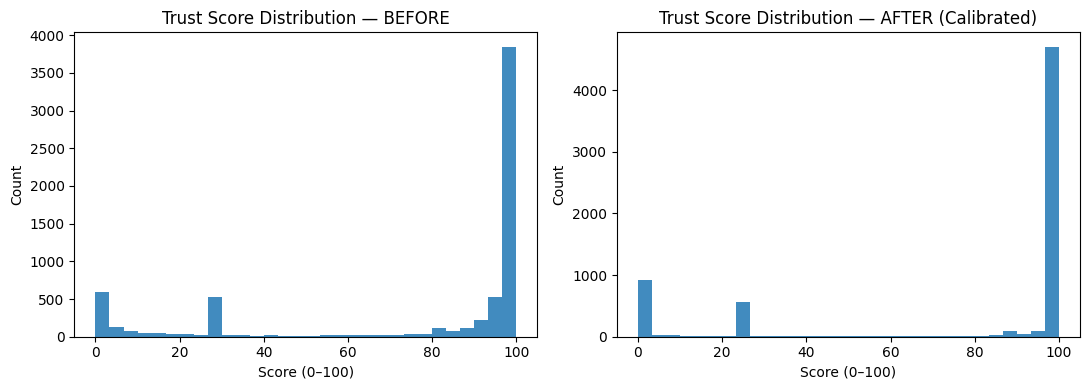

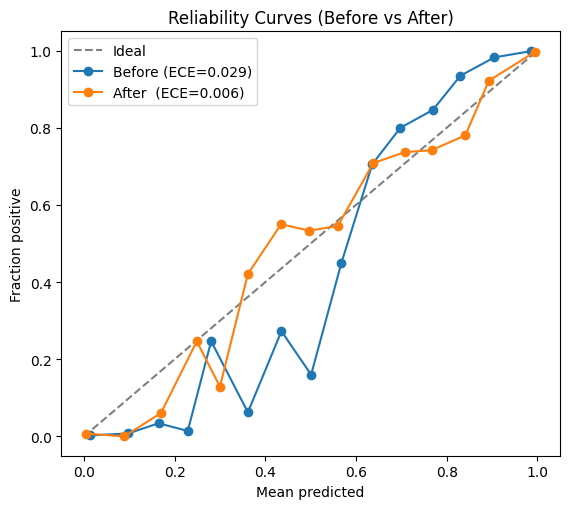

In [8]:
# %% [code] 4_FIGURE7_AND_RELIABILITY
import matplotlib.pyplot as plt

# BEFORE: simulate "pre-fix" scores if you still have them; otherwise, use an uncalibrated baseline
# For demo, we take an uncalibrated RF as 'before':
rf_uncal = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_uncal.fit(X_train, y_train)
y_prob_before = rf_uncal.predict_proba(X_test)[:,1]

# Reliability tools
def reliability_curve(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    xs, ys = [], []
    for b in range(n_bins):
        m = ids==b
        if m.sum()==0: 
            continue
        xs.append(y_prob[m].mean())
        ys.append(y_true[m].mean())
    return np.array(xs), np.array(ys)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        m = ids==b
        if m.sum()==0: 
            continue
        ece += (m.mean()) * abs(y_true[m].mean() - y_prob[m].mean())
    return float(ece)

# Figure 7: hist before vs after (0–100)
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.hist((y_prob_before*100).round(2), bins=30, alpha=0.85)
plt.title("Trust Score Distribution — BEFORE")
plt.xlabel("Score (0–100)"); plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist((y_prob_after*100).round(2), bins=30, alpha=0.85)
plt.title("Trust Score Distribution — AFTER (Calibrated)")
plt.xlabel("Score (0–100)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Reliability curve + ECE
mp_b, fp_b = reliability_curve(y_test.values, y_prob_before)
mp_a, fp_a = reliability_curve(y_test.values, y_prob_after)
ece_b = expected_calibration_error(y_test.values, y_prob_before)
ece_a = expected_calibration_error(y_test.values, y_prob_after)

plt.figure(figsize=(5.8,5.2))
plt.plot([0,1],[0,1],'--',color='gray', label='Ideal')
plt.plot(mp_b, fp_b, marker='o', label=f'Before (ECE={ece_b:.3f})')
plt.plot(mp_a, fp_a, marker='o', label=f'After  (ECE={ece_a:.3f})')
plt.title("Reliability Curves (Before vs After)")
plt.xlabel("Mean predicted"); plt.ylabel("Fraction positive")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# # %% [code] 5_SAVE_ARTIFACTS
# import joblib

# joblib.dump(scaler, "../../models/test_trust_score_scaler.pkl")

# # If you used Option A (calibrated classifier):
# joblib.dump(cal_rf, "../../models/test_trust_score_model.pkl")
# joblib.dump({"type": "classifier_calibrated"}, "../../models/test_trust_score_meta.pkl")

# # If you used Option B (regressor + isotonic):
# # joblib.dump(gbr, "trust_score_model.pkl")
# # joblib.dump(iso, "trust_score_calibrator.pkl")
# # joblib.dump({"type": "regressor_plus_isotonic"}, "trust_score_meta.pkl")


In [12]:
X_train.head(5)

,noOfTrx.1,Balance,self_transfer_ratio,circular_txn_count,circular_txn_ratio,avg_txn_value_eth,txn_spike_score,value_std_dev,avg_gas_used,avg_gas_price,...,nft_txn_count,first_txn_time_of_day,erc20_token_diversity,tx_direction_ratio,contract_interaction_ratio,value_entropy,average_txn_interval,new_token_interaction_count,token_approval_count,sbt_poap_event_count
22454,0.0003,2.120562e-12,0.0,0.000101,0.336734,1.611200e-08,0.000805,7.506127e-09,0.003744,0.000013,...,0.0,0.304348,0.0,0.000212,0.000000,0.119280,1.904334e-07,0.0003,0.0,0.0
25605,0.0003,8.825259e-13,0.0,0.000000,0.000000,1.185959e-03,0.000805,2.647207e-04,0.001458,0.000053,...,0.0,0.217391,0.0,0.000106,0.000000,0.119280,2.145099e-01,0.0002,0.0,0.0
8359,0.0007,3.023690e-04,0.0,0.000000,0.000000,8.489566e-04,0.000805,5.812005e-04,0.002850,0.000024,...,0.0,0.739130,0.0,0.000071,0.000000,0.211275,1.355766e-01,0.0002,0.0,0.0
18852,0.0031,0.000000e+00,0.0,0.000000,0.000000,4.260085e-06,0.000805,3.989517e-06,0.001458,0.000034,...,0.0,0.000000,0.0,0.000034,0.000000,0.320622,7.745707e-05,0.0004,0.0,0.0
23171,0.1899,0.000000e+00,0.0,0.000000,0.000000,2.173674e-07,0.006441,4.228253e-07,0.012335,0.000048,...,0.0,1.000000,0.0,0.000006,0.000527,0.336095,4.640186e-05,0.0002,0.0,0.0


In [14]:
X_train.columns

Index(['noOfTrx.1', 'Balance', 'self_transfer_ratio', 'circular_txn_count',
       'circular_txn_ratio', 'avg_txn_value_eth', 'txn_spike_score',
       'value_std_dev', 'avg_gas_used', 'avg_gas_price', 'active_days',
       'wallet_age_days', 'unique_counterparties', 'failed_txn_ratio',
       'eth_inflow_outflow_ratio', 'erc20_txn_count', 'nft_txn_count',
       'first_txn_time_of_day', 'erc20_token_diversity', 'tx_direction_ratio',
       'contract_interaction_ratio', 'value_entropy', 'average_txn_interval',
       'new_token_interaction_count', 'token_approval_count',
       'sbt_poap_event_count'],
      dtype='object')